# Mini Project2


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from surprise import SVD
from surprise import accuracy, Dataset, Reader

In [40]:
url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [41]:
data = np.array(pd.read_csv('data.csv'))
movies = np.array(pd.read_csv('movies.csv'))
train = np.array(pd.read_csv('train.csv'))
test = np.array(pd.read_csv('test.csv'))

## Surprise - setup

In [42]:
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

# reader for range of ratings
reader = Reader(rating_scale=(1,5))

# convert train numpy array to data frame
train_df = pd.DataFrame(train, columns= ['User ID', 'Movie ID', 'Rating'])

# create surprise data object
train_ds = Dataset.load_from_df(train_df[['User ID','Movie ID', 'Rating']], reader)

# convert to train set
train_ts = train_ds.build_full_trainset()
train_ts.n_users = M # specify number of users
train_ts.n_items = N # specify number of items

Factorizing with  943  users,  1682  movies.


## Get final model

In [43]:
eta = 1e-2 # learning rate
reg = 1e-1 # regularization term
algo = SVD(n_factors=K,biased=False,lr_all=eta,reg_all=reg,n_epochs=300)
algo.fit(train_ts)
predictions_train = algo.test(train)
predictions_test = algo.test(test)
accuracy.rmse(predictions_train)
accuracy.rmse(predictions_test)

# extract matrix
U = algo.pu
V = algo.qi
print("U is matrix of size ",U.shape[0]," by ",U.shape[1])
print("V is matrix of size ",V.shape[0]," by ",V.shape[1])

RMSE: 0.7010
RMSE: 0.9209
U is matrix of size  943  by  20
V is matrix of size  1682  by  20


# Visualization 

In [44]:
def vis_projection(u,v, bias_movie=0, bias_user=0):
    u_mean_cetered = u - np.mean(u, axis=0)[np.newaxis,:]
    v_mean_cetered = v - np.mean(v, axis=0)[np.newaxis,:]
    [u_U, S, u_Vh] = np.linalg.svd(np.transpose(u_mean_cetered))
    [v_U, S, v_Vh] = np.linalg.svd(np.transpose(v_mean_cetered))
    u_U_2 = u_U[:,:2]
    u_proj = np.matmul(np.transpose(u_U_2), np.transpose(u_mean_cetered))
    v_U_2 = v_U[:,:2]
    v_proj = np.matmul(np.transpose(v_U_2), np.transpose(v_mean_cetered))

    return u_proj, v_proj

def vis_plot(u,v, filename, movie_select, movie_names, moving_names = "", moving_dist_x = 0, moving_dist_y = 0):
    u_proj, v_proj = vis_projection(u,v)
    fig,ax = plt.subplots()
    #fig.set_size_inches(10,10)
    v_proj_sub0 = v_proj[0, movie_select]
    v_proj_sub1 = v_proj[1, movie_select]
    ax.scatter(v_proj_sub0, v_proj_sub1)
    for i in range(len(movie_select)):
        stringv = movie_names[i, 1]
        print(stringv)
        if stringv == moving_names:
            ax.annotate(stringv, (v_proj_sub0[i] + moving_dist_x, v_proj_sub1[i]+moving_dist_y), size=8)
        else:
            ax.annotate(stringv, (v_proj_sub0[i], v_proj_sub1[i]), size=8)
        

    #ax.set_xlim(-1,1.5)
    ax.grid(which='major')
    plt.xlabel("Latent Feature 1")
    plt.ylabel("Latent Feature 2")
    plt.savefig(filename)
    return

## Intereseting visualization for Piazza

Star Wars (1977)
Stargate (1994)
Lone Star (1996)
Unhook the Stars (1996)
Star Trek: First Contact (1996)
Star Trek VI: The Undiscovered Country (1991)
Star Trek: The Wrath of Khan (1982)
Star Trek III: The Search for Spock (1984)
Star Trek IV: The Voyage Home (1986)
Starship Troopers (1997)
Star Trek: Generations (1994)
Star Trek: The Motion Picture (1979)
Star Trek V: The Final Frontier (1989)
Evening Star, The (1996)
Star Maker, The (Uomo delle stelle, L') (1995)
Star Maps (1997)
Star Kid (1997)
Stars Fell on Henrietta, The (1995)
Frankie Starlight (1995)


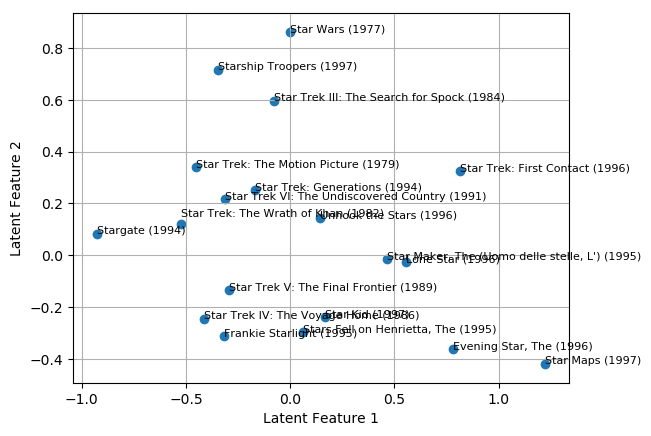

In [45]:
# Interesting visualization
star_movies = []
for i in range(len(movies)):
    if "Star" in movies[i,1]:
        star_movies.append(i)


movie_titles = movies[star_movies]

vis_plot(U, V, 'Surprise_figs/Interesting.pdf', star_movies, movie_titles,"Star Trek: The Wrath of Khan (1982)", 0.0, 0.03)

## Any 10 movies

In [46]:
movie_select = [1, 2, 4, 10, 11, 16, 20, 22, 27, 32] # all thrillers
movie_titles = movies[movie_select] 
movie_titles[:,1]

array(['GoldenEye (1995)', 'Four Rooms (1995)', 'Copycat (1995)',
       'Seven (Se7en) (1995)', 'Usual Suspects, The (1995)',
       'From Dusk Till Dawn (1996)', 'Muppet Treasure Island (1996)',
       'Taxi Driver (1976)', 'Apollo 13 (1995)', 'Desperado (1995)'],
      dtype=object)

GoldenEye (1995)
Four Rooms (1995)
Copycat (1995)
Seven (Se7en) (1995)
Usual Suspects, The (1995)
From Dusk Till Dawn (1996)
Muppet Treasure Island (1996)
Taxi Driver (1976)
Apollo 13 (1995)
Desperado (1995)


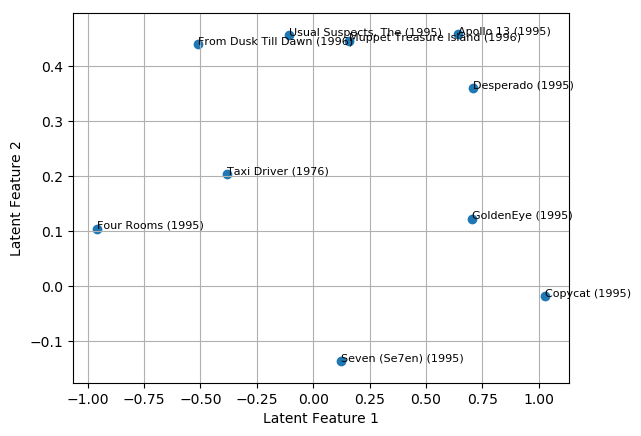

In [47]:
vis_plot(U, V, 'Surprise_figs/Part_a.pdf', movie_select, movie_titles)

## 10 most popular movies

In [48]:
#find the ten most popular movie
movie_count = np.zeros(N)
for i in range(len(train)):
    movie_count[int(train[i,1])-1] += 1
movie_count = movie_count/len(train)
movie_idx = np.argsort(movie_count)
movie_idx = movie_idx[::-1]
movie_idx = movie_idx[:10]
movie_idx = movie_idx + 1
movie_idx

array([ 50, 100, 181, 258, 294, 288, 286,   1, 300, 121], dtype=int64)

In [49]:
print("The ten most popular movies are: ")
for i in range(10):
    print(movies[movie_idx[i]-1,1])

The ten most popular movies are: 
Star Wars (1977)
Fargo (1996)
Return of the Jedi (1983)
Contact (1997)
Liar Liar (1997)
Scream (1996)
English Patient, The (1996)
Toy Story (1995)
Air Force One (1997)
Independence Day (ID4) (1996)


Star Wars (1977)
Fargo (1996)
Return of the Jedi (1983)
Contact (1997)
Liar Liar (1997)
Scream (1996)
English Patient, The (1996)
Toy Story (1995)
Air Force One (1997)
Independence Day (ID4) (1996)


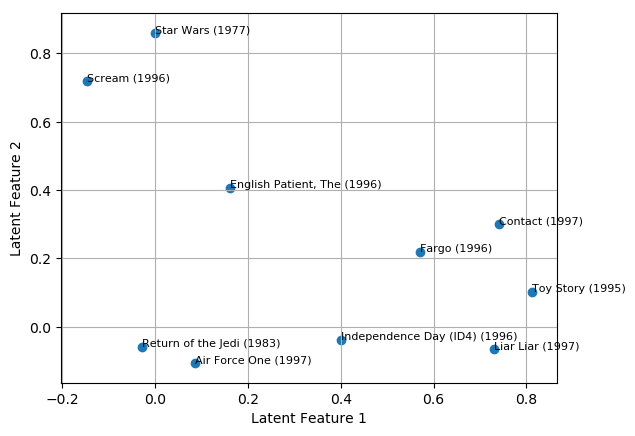

In [50]:
movie_select = movie_idx - 1
movie_titles = movies[movie_select]
vis_plot(U, V, 'Surprise_figs/Part_b_most_popular.pdf', movie_select, movie_titles)

## 10 best movies

In [51]:
#find the ten best movies
movie_rating = np.zeros(N)
movie_count = np.zeros(N)
for i in range(len(train)):
    movie_rating[int(train[i,1])-1] += train[i,2]
    movie_count[int(train[i,1])-1] += 1
movie_rating = movie_rating/movie_count
movie_rating[np.isnan(movie_rating)] = 0
movie_idx = np.argsort(movie_rating)
movie_idx = movie_idx[::-1]
movie_idx = movie_idx[:10]

C:\Users\micha\AppData\Local\Temp\ipykernel_29160\607911051.py:7: RuntimeWarning: invalid value encountered in divide
  movie_rating = movie_rating/movie_count


In [52]:
print("The ten best movies are: ")
for i in range(10):
    print(movies[movie_idx[i],1])
    print(movie_rating[movie_idx[i]])

The ten best movies are: 
Great Day in Harlem, A (1994)
5.0
Saint of Fort Washington, The (1993)
5.0
Aiqing wansui (1994)
5.0
Entertaining Angels: The Dorothy Day Story (1996)
5.0
They Made Me a Criminal (1939)
5.0
Prefontaine (1997)
5.0
Santa with Muscles (1996)
5.0
Marlene Dietrich: Shadow and Light (1996) 
5.0
The Deadly Cure (1996)
5.0
Someone Else's America (1995)
5.0


Great Day in Harlem, A (1994)
Saint of Fort Washington, The (1993)
Aiqing wansui (1994)
Entertaining Angels: The Dorothy Day Story (1996)
They Made Me a Criminal (1939)
Prefontaine (1997)
Santa with Muscles (1996)
Marlene Dietrich: Shadow and Light (1996) 
The Deadly Cure (1996)
Someone Else's America (1995)


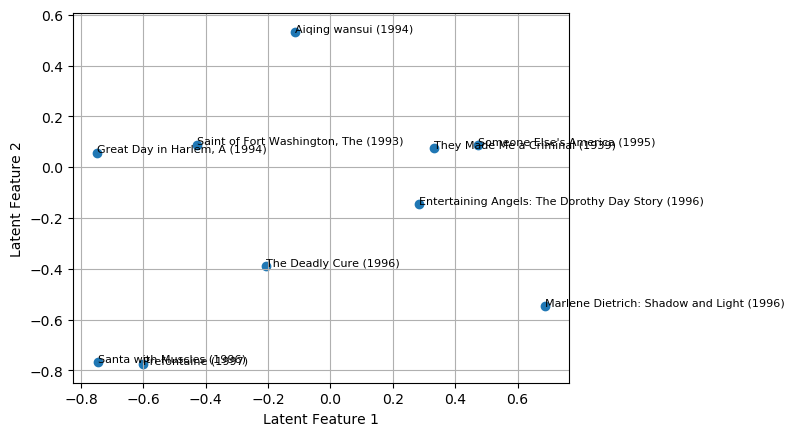

In [53]:
# Get the plot
movie_select = movie_idx
movie_titles = movies[movie_select]
vis_plot(U, V, 'Surprise_figs/Part_c_best_movies.pdf', movie_select, movie_titles)

## 10 movies from three genres

In [54]:
# Choose the genres Sci-Fi, Comedy, and Adventure, and find the corresponding movies and put them into separate lists
genres = ['Sci-Fi', 'Comedy', 'Adventure']
data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

genres = ['Sci-Fi', 'Comedy', 'Adventure']
movies_genres = movies[movies[genres].sum(axis=1) > 0]
print(movies_genres[['Movie ID', 'Movie Title', 'Sci-Fi', 'Comedy', 'Adventure']])


      Movie ID                      Movie Title  Sci-Fi  Comedy  Adventure
0            1                 Toy Story (1995)       0       1          0
1            2                 GoldenEye (1995)       0       0          1
3            4                Get Shorty (1995)       0       1          0
6            7            Twelve Monkeys (1995)       1       0          0
7            8                      Babe (1995)       0       1          0
...        ...                              ...     ...     ...        ...
1658      1659  Getting Away With Murder (1996)       0       1          0
1663      1664   8 Heads in a Duffel Bag (1997)       0       1          0
1667      1668        Wedding Bell Blues (1996)       0       1          0
1669      1670                   Tainted (1998)       0       1          0
1680      1681              You So Crazy (1994)       0       1          0

[679 rows x 5 columns]


### Sci-Fi

Twelve Monkeys (1995)
Net, The (1995)
Strange Days (1995)
Star Wars (1977)
Stargate (1994)
Jurassic Park (1993)
Robert A. Heinlein's The Puppet Masters (1994)
Blade Runner (1982)
Terminator 2: Judgment Day (1991)
Heavy Metal (1981)


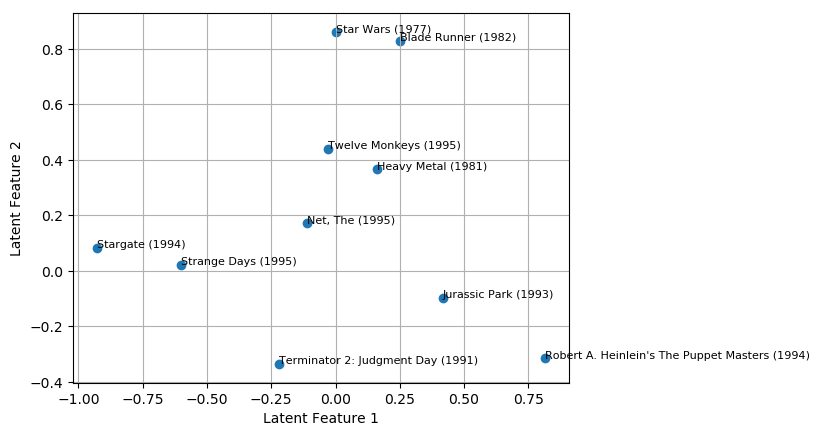

In [55]:
# Get 10 of the sci-fi movies
data_arr = np.array(pd.read_csv('data.csv'))
movies_arr = np.array(pd.read_csv('movies.csv'))
train_arr = np.array(pd.read_csv('train.csv'))
test_arr = np.array(pd.read_csv('test.csv'))

movie_select = movies_genres[movies_genres['Sci-Fi'] == 1]['Movie ID']
movie_select = movie_select[:10]
movie_select = movie_select.to_numpy()
movie_titles = movies_arr[movie_select-1]
vis_plot(U, V, 'Surprise_figs/Part_d_Sci-Fi.pdf', movie_select-1, movie_titles)

### Comedy

Toy Story (1995)
Get Shorty (1995)
Babe (1995)
Mighty Aphrodite (1995)
French Twist (Gazon maudit) (1995)
From Dusk Till Dawn (1996)
Muppet Treasure Island (1996)
Birdcage, The (1996)
Brothers McMullen, The (1995)
Batman Forever (1995)


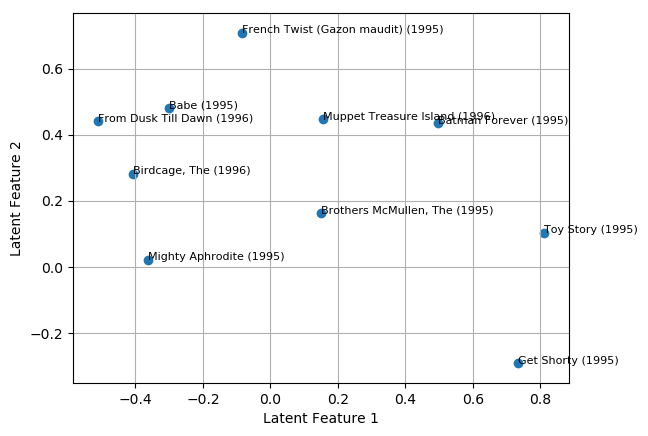

In [56]:
# Get 10 of the comedy movies
movie_select = movies_genres[movies_genres['Comedy'] == 1]['Movie ID']
movie_select = movie_select[:10]
movie_select = movie_select.to_numpy()
movie_titles = movies_arr[movie_select-1]
vis_plot(U, V, 'Surprise_figs/Part_d_Comedy.pdf', movie_select-1, movie_titles)

### Adventure

GoldenEye (1995)
Muppet Treasure Island (1996)
Rumble in the Bronx (1995)
Batman Forever (1995)
Free Willy 2: The Adventure Home (1995)
Star Wars (1977)
Stargate (1994)
Free Willy (1993)
Jurassic Park (1993)
Dances with Wolves (1990)


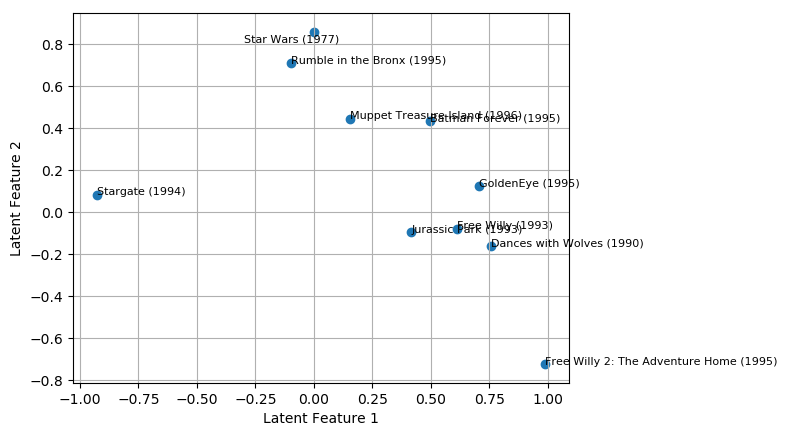

In [57]:
# Get 10 of the adventure movies
movie_select = movies_genres[movies_genres['Adventure'] == 1]['Movie ID']
movie_select = movie_select[:10]
movie_select = movie_select.to_numpy()
movie_titles = movies_arr[movie_select-1]
vis_plot(U, V, 'Surprise_figs/Part_d_Adventure.pdf', movie_select-1, movie_titles, "Star Wars (1977)", -0.3, -0.05)